In [1]:
!trash-empty

In [2]:
!nvidia-smi

Wed Oct 30 15:25:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    69W / 300W |  14332MiB / 16130MiB |     93%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   51C    P0    63W / 300W |  13754MiB / 16130MiB |     88%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
import sys
package_path = 'EfficientNet-PyTorch/'
sys.path.append(package_path)

from efficientnet_pytorch import EfficientNet
from radam import RAdam, PlainRAdam, AdamW

In [5]:
import os
import gc
import pydicom
import numpy as np 
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models, transforms as T
import torch.nn.functional as F

import cv2
import fastai
from fastai.vision import *
from fastai.callbacks.tracker import SaveModelCallback

from albumentations import (
    Compose, RandomRotate90, HorizontalFlip, VerticalFlip, Rotate, ShiftScaleRotate, Transpose,
    Normalize, RandomScale, CenterCrop, RandomGamma, GridDistortion,
    IAAPerspective, JpegCompression, ToGray, ChannelShuffle, RGBShift, CLAHE,
    RandomBrightnessContrast, RandomSunFlare, Cutout, OneOf, Resize
)
from albumentations.pytorch import ToTensor

import pretrainedmodels
print(pretrainedmodels.model_names)

import warnings
warnings.filterwarnings('ignore')

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


## Config

In [6]:
config = {
    'SEED': 42,
    'CLASSES': 6,
    'CHANNELS': 3,
    'PATH_DATA': 'data/',
    'PATH_WEIGHTS': '/home/jupyter/Nikita/',
    'DEVICE': 'cuda',
    'BATCH_SIZE': 48,
    'IMG_SIZE': 512,
    'NUM_WORKERS_ON_MACHINE': 8,
    'VAL_SIZE': 0.20,
    'MODEL_NAME': 'EffnetB0-fp16-HardAugs',
    'USE_ANGULAR': False,
    'USE_BN': False,
    'TrainTA': True,
    'TestTA': True,
    'LR': 1e-4,
    'LR_STR': '1e-4',
    'TURN_OFF_ON_N_EPOCHS': 0,
}

In [7]:
def seed_torch(seed=42):
    import random; import os
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.cuda.empty_cache()
    
seed_torch(config['SEED'])

## Data

In [8]:
df = pd.read_csv(config['PATH_DATA']+'stage_1_train.csv')
train_features = pd.read_feather(config['PATH_DATA'] + 'df_trn.fth').dropna(subset=['img_pct_window'])
train_labels = pd.read_feather(config['PATH_DATA'] + 'labels.fth')

print(df.shape)
print(df['Label'].value_counts(normalize=True))

(4045572, 2)
0    0.942947
1    0.057053
Name: Label, dtype: float64


In [ ]:
comb = train_features.join(train_labels.set_index('ID'), 'SOPInstanceUID')
print(comb.shape)

comb = comb.assign(pct_cut = pd.cut(comb.img_pct_window, [0,0.02,0.05,0.1,0.2,0.3,1]))
comb.drop(comb.query('img_pct_window<0.02').index, inplace=True)
print(comb.shape)

In [9]:
newtable = df.copy()
new = newtable["ID"].str.split("_", n = 1, expand = True)
newX = new[1].str.split("_", n = 1, expand = True)
newtable['Image_ID'] = newX[0]
newtable['Sub_type'] = newX[1]

image_ids = newtable.Image_ID.unique()
train_df = pd.DataFrame(np.array([image_ids, np.zeros(len(image_ids))]).transpose(), columns=["id", "labels"])
labels = {i : "" for i in image_ids}

newtable = newtable[newtable.Label == 1]
for name, group in newtable.groupby("Image_ID"):
    labels[name] = " ".join(group.Sub_type)
    
train_df = pd.DataFrame(np.array([list(labels.keys()), list(labels.values())]).transpose(), columns=["id", "labels"])
train_df.id = "ID_" + train_df.id 

train_df = train_df.merge(comb, left_on='id', right_on='SOPInstanceUID', how='right')
train_df.id += ".dcm"

# train_df['labels'].hist(bins=len(train_df.labels.unique()), figsize=[12,6], xrot=90)
print(train_df.shape)
print(train_df['labels'].value_counts(normalize=True))

del new, newX, newtable, labels, df, train_features, train_labels, comb
gc.collect();

(674258, 43)
                                                                        0.855985
subdural any                                                            0.042875
subarachnoid any                                                        0.021827
intraparenchymal any                                                    0.020663
intraventricular any                                                    0.013220
intraparenchymal intraventricular any                                   0.009388
subarachnoid subdural any                                               0.006902
intraparenchymal subarachnoid any                                       0.005356
intraventricular subarachnoid any                                       0.004785
intraparenchymal subdural any                                           0.004378
intraparenchymal subarachnoid subdural any                              0.002991
intraparenchymal intraventricular subarachnoid any                      0.002612
epidural any   

In [10]:
broken_images = ['ID_6431af929.dcm']
broken_indexes = [train_df[train_df.id == i].index for i in broken_images]
train_df.drop(train_df.index[broken_indexes], inplace=True)

In [11]:
train_df.head(2)

,id,labels,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,...,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1
0,ID_63eb1e259.dcm,,ID_63eb1e259,CT,ID_a449357f,ID_62d125e5b2,ID_0be5c0d1b3,,-125.0,1.0,...,1,0.488281,6,2465,544.463779,650.349965,1.0,36.0,1.0,80.0
1,ID_2669954a7.dcm,,ID_2669954a7,CT,ID_363d5865,ID_a20b80c7bf,ID_3564d584db,,-156.0,1.0,...,1,0.488281,0,3788,438.149899,550.336298,1.0,47.0,1.0,80.0


In [12]:
group_splitter = GroupShuffleSplit(test_size=config['VAL_SIZE'], n_splits=2, random_state=config['SEED'])
train_inds, val_inds = next(group_splitter.split(train_df, groups=train_df['PatientID']))  # StudyInstanceUID
train_subset, val_subset = train_df.iloc[train_inds], train_df.iloc[val_inds]

train_subset['is_valid'] = False
val_subset['is_valid'] = True
train_df = train_subset.append(val_subset)
train_df = train_df[['id', 'labels', 'is_valid']]

## Preprocessing

In [13]:
# https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(img, window_center,window_width, intercept, slope):
    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

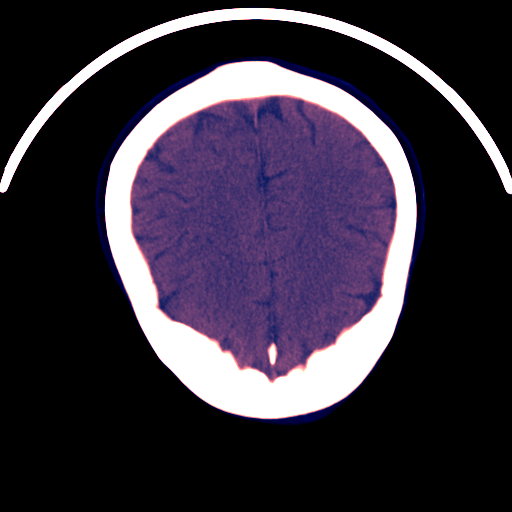

In [14]:
all_transforms = Compose([
    Resize(config['IMG_SIZE'], config['IMG_SIZE'], p=1.0),
    HorizontalFlip(),
    VerticalFlip(),
    RandomRotate90(),
    ShiftScaleRotate(scale_limit=0.1, rotate_limit=45),
    GridDistortion(num_steps=5, distort_limit=[-0.3,0.3], interpolation=1, border_mode=4),
    RandomGamma(gamma_limit=[80,120]),
    # ToTensor()
])

# https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/110728#latest-642755
def new_open_image(path, div=True, convert_mode=None, after_open=None):
    dcm = pydicom.dcmread(str(path))
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    intercept, slope = get_windowing(dcm)
    pixel_array = dcm.pixel_array.astype(np.int16) # "uint8"
    im_1 = window_image(pixel_array, 40, 80, intercept, slope) # brain
    im_2 = window_image(pixel_array, 80, 200, intercept, slope) # subdural
    im_3 = window_image(pixel_array, 40, 380, intercept, slope) # bone
    im_1 = (im_1 - 0) / 80
    im_2 = (im_2 - (-20)) / 200
    im_3 = (im_3 - (-150)) / 380
    im = np.stack((im_1, im_2, im_3), axis=-1)
    
    if config['TrainTA']:
        transformed_im = all_transforms(image=im)['image']
        x = pil2tensor(transformed_im, dtype=np.float32)
    else:
        x = pil2tensor(im, dtype=np.float32)
        
    return Image(x)

vision.data.open_image = new_open_image
tmp = new_open_image('data/stage_1_train_images/ID_63eb1e259.dcm')
tmp

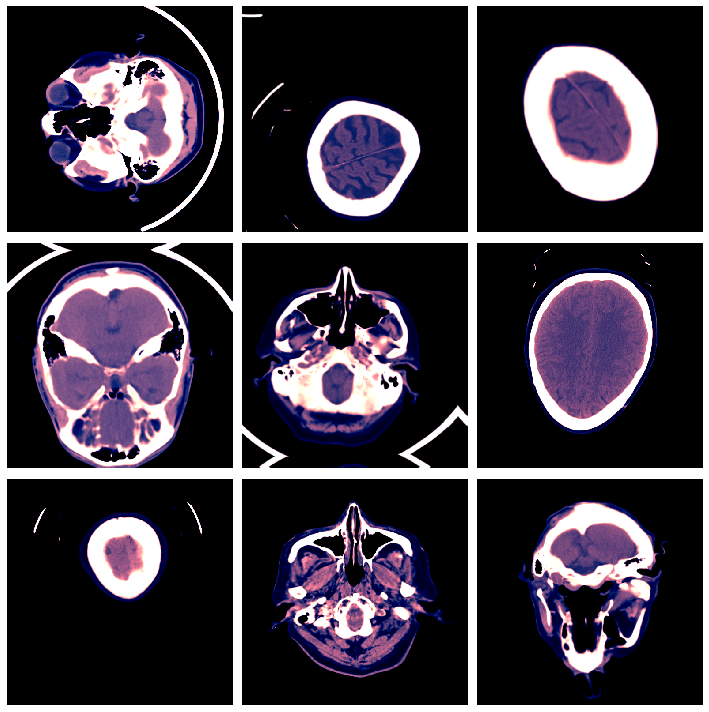

In [15]:
im_list = ImageList.from_df(train_df, path=config['PATH_DATA']+"stage_1_train_images")
data = (im_list.split_from_df()
               .label_from_df(label_delim=" ")
               .databunch(bs=config['BATCH_SIZE'], num_workers=config['NUM_WORKERS_ON_MACHINE'])
               .normalize(imagenet_stats))

data.show_batch(3, figsize=(10,10))

## Model

In [16]:
def get_effnet_model(model_version=0, num_classes=1000, num_channels=3,
                     pretrained=True, use_bn=False, use_angular=False):
    if pretrained:
        preloaded = EfficientNet.from_pretrained('efficientnet-b{}'.format(model_version), num_classes=num_classes)
    else:
        preloaded = None
    #print(preloaded)
    
    if use_bn:
        preloaded = nn.Sequential(OrderedDict([
                        ('norm0', nn.BatchNorm2d(num_channels)),
                        ('model', preloaded)]))
        model = preloaded.model
    else:
        model = preloaded
    
    if num_channels != 3:
        trained_kernel = model._conv_stem.weight
        new_conv = Conv2dStaticSamePadding(num_channels, 48,
                                           kernel_size=(3,3), stride=(2,2), bias=False,
                                           image_size=config['IMG_SIZE'])
        with torch.no_grad():
            new_conv.weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)]*num_channels, dim=1)
        model._conv_stem = new_conv
            
    fc_input_features = model._fc.in_features
    if use_angular:
        model._fc = AngleSimpleLinear(fc_input_features, num_classes)
    else:
        model._fc = nn.Linear(fc_input_features, num_classes, bias=True)
    
    return preloaded

In [17]:
model = get_effnet_model(model_version=0,
                         num_classes=config['CLASSES'],
                         num_channels=config['CHANNELS'],
                         use_bn=config['USE_BN'],
                         use_angular=config['USE_ANGULAR'])
model.to(config['DEVICE']);

Loaded pretrained weights for efficientnet-b0


## Learner

In [18]:
data.classes

['any',
 'epidural',
 'intraparenchymal',
 'intraventricular',
 'subarachnoid',
 'subdural']

In [19]:
#!git clone https://github.com/fastai/fastai_dev.git
from fastai_dev.fastai2.basics import BaseLoss

# because target='any' is the 1th column in y_true
labels_weight = torch.tensor([2.0, 1.0, 1.0, 1.0, 1.0, 1.0]).to(config['DEVICE'])
loss = BaseLoss(nn.BCEWithLogitsLoss,
                pos_weight=labels_weight, floatify=True, flatten=False,
                is_2d=False, activation=torch.sigmoid)

learn = Learner(data=data,
                model=model,
                loss_func=loss,
                opt_func=partial(RAdam, weight_decay=1e-4),
                # metrics=[fastai.metrics.auc_roc_score]
                callback_fns=ShowGraph).to_fp16()
# learn.model = nn.DataParallel(learn.model)
learn.path = Path(config['MODEL_NAME'])
checkpoint_callback = SaveModelCallback(learn, name=config['MODEL_NAME'],
                                        every='epoch', monitor='valid_loss')

---

epoch,train_loss,valid_loss,time
0,0.132125,0.125011,1:24:58
1,0.111548,0.107752,1:25:27
2,0.094268,0.094208,1:26:41
3,0.091537,0.090122,1:26:21
4,0.084618,0.086464,1:26:04
5,0.079065,0.085902,1:26:21
6,0.078946,0.084321,1:26:28
7,0.071397,0.084597,1:26:13
8,0.070245,0.083904,1:26:26
9,0.068513,0.084344,1:26:34


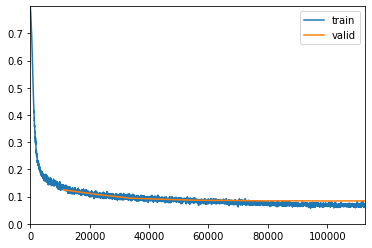

In [20]:
learn.unfreeze()
learn.fit_one_cycle(
    10,
    max_lr=config['LR'],
    callbacks=[checkpoint_callback],
)

## PAY ATTENTION! DANGEROUS!
## BICYCLE D4 TTA CODE BELOW! :)

In [20]:
from albumentations import DualTransform

class Rotate90(DualTransform):
    def apply(self, img, factor=1, **params):
        """
        Args:
            factor (int): number of times the input will be rotated by 90 degrees.
        """
        return np.ascontiguousarray(np.rot90(img, factor))

    def get_transform_init_args_names(self):
        return ()
    
class Rotate180(DualTransform):
    def apply(self, img, factor=2, **params):
        """
        Args:
            factor (int): number of times the input will be rotated by 90 degrees.
        """
        return np.ascontiguousarray(np.rot90(img, factor))

    def get_transform_init_args_names(self):
        return ()
    
class Rotate270(DualTransform):
    def apply(self, img, factor=3, **params):
        """
        Args:
            factor (int): number of times the input will be rotated by 90 degrees.
        """
        return np.ascontiguousarray(np.rot90(img, factor))

    def get_transform_init_args_names(self):
        return ()

In [21]:
def change_open_image_function(tta_index):
    resize_transform = Resize(config['IMG_SIZE'], config['IMG_SIZE'], p=1.0)
    
    def new_open_image(path, div=True, convert_mode=None, after_open=None):
        dcm = pydicom.dcmread(str(path))
        if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
            correct_dcm(dcm)
        intercept, slope = get_windowing(dcm)
        pixel_array = dcm.pixel_array.astype(np.int16) # "uint8"
        im_1 = window_image(pixel_array, 40, 80, intercept, slope) # brain
        im_2 = window_image(pixel_array, 80, 200, intercept, slope) # subdural
        im_3 = window_image(pixel_array, 40, 380, intercept, slope) # bone
        im_1 = (im_1 - 0) / 80
        im_2 = (im_2 - (-20)) / 200
        im_3 = (im_3 - (-150)) / 380
        im = np.stack((im_1, im_2, im_3), axis=-1)
        
        if tta_index == 0:
            tta_transforms = Compose([resize_transform])
        elif tta_index == 1:
            tta_transforms = Compose([resize_transform, HorizontalFlip(p=1.0)])
        elif tta_index == 2:
            tta_transforms = Compose([resize_transform, VerticalFlip(p=1.0)])
        elif tta_index == 3:
            tta_transforms = Compose([resize_transform, Rotate90(p=1.0)])
        elif tta_index == 4:
            tta_transforms = Compose([resize_transform, Rotate180(p=1.0)])
        elif tta_index == 5:
            tta_transforms = Compose([resize_transform, Rotate270(p=1.0)])
        
        transformed_im = tta_transforms(image=im)['image']
        x = pil2tensor(transformed_im, dtype=np.float32)
        return Image(x)
    
    vision.data.open_image = new_open_image

---

In [22]:
best_epoch = 8
learn.load('{0}{1}/models/{1}_{2}'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], best_epoch))
submission = pd.read_csv(config['PATH_DATA']+"stage_1_sample_submission.csv")
test_fnames = submission["ID"].str.split("_", n=2, expand=True)[1].unique()
test_fnames = pd.DataFrame("ID_" + test_fnames + ".dcm")
test_im_list = ImageList.from_df(test_fnames, path=config['PATH_DATA']+"stage_1_test_images")
learn.data.add_test(test_im_list)

In [23]:
tta_preds = np.zeros((len(test_im_list), config['CLASSES']))

TTA = 6
for i in range(TTA):
    change_open_image_function(i)
    preds = learn.get_preds(ds_type=DatasetType.Test)
    preds = preds[0].numpy()
    tta_preds += preds / TTA
    print(preds.shape)
    print('TTA #{} completed'.format(i))
    
np.save('predictions/{0}_{1}_lr{2}_TTA_D4.npy'.format(config['MODEL_NAME'], best_epoch, config['LR_STR']),
        tta_preds)

(78545, 6)
TTA #5 completed


In [24]:
print('EPOCH #{} TTA D4'.format(best_epoch))
submission.Label = np.roll(tta_preds, -1, axis=1).reshape(-1)
submission.to_csv("submits/{0}_{1}_lr{2}_TTA_D4.csv".format(config['MODEL_NAME'], best_epoch, config['LR_STR']), index=False)
# submission['Label'].hist(bins=100, figsize=[12,6], xrot=90)
submission['htype'] = submission["ID"].str.split("_", n=2, expand=True)[2]
submission.groupby('htype').mean().head(6)

EPOCH #8 TTA D4


,Label
htype,
any,0.129857
epidural,0.005442
intraparenchymal,0.042057
intraventricular,0.030422
subarachnoid,0.045730
subdural,0.052508
